# Testing notebook for conjugacy

### Currently (somewhat) implemented features
- Separated Conjugate sampler into more managable ConjugacyPair objects.
- Verification whether the specified conjugacy is supported and/or correct.

### Possible additional improvements
- Support for specifying conjugacy through `sqrtcov` and `sqrtprec`.
    - Through `prec` and `cov` is now supported.
- Allow for more complicated dependancies, e.g.,  a scaled precision matrix `prec = lambda l : l*L`.
    - For this, the way that `sqrtprec` is used in conjugacy needs to be updated.
    - Regression test that tests for linearity. (Scalar, vector and matrix valued)


In [1]:
# Load modules and set-up test problem
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from cuqi.testproblem import Deconvolution1D
from cuqi.distribution import Gaussian, GMRF, Gamma, JointDistribution
from cuqi.implicitprior import RegularizedGaussian, RegularizedGMRF
from cuqi.sampler import LinearRTO, RegularizedLinearRTO, Gibbs, Conjugate, GaussianGammaPair, RegularizedGaussianGammaPair
from cuqi.geometry import Continuous1D

n = 128
A, y_data, info = Deconvolution1D(dim=n, phantom='square').get_components()


In [2]:
l = Gamma(1, 1e-4)
y = Gaussian(np.zeros(n), prec = lambda l:l)

joint = JointDistribution(l,  y)
target = joint(y = np.zeros(n))

conjugate = Conjugate(target)
print(conjugate.validate())

True


In [3]:
l = Gamma(1, 1e-4)
y = Gaussian(np.zeros(n), prec = lambda l:1.0/l)

joint = JointDistribution(l,  y)
target = joint(y = np.zeros(n))

conjugate = Conjugate(target)
print(conjugate.validate())


ValueError: Conjugacy on the variable l in attribute prec is not incorrect or unsupported

In [4]:
l = Gamma(1, 1e-4)
y = Gaussian(np.zeros(n), cov = lambda l:1.0/l)

joint = JointDistribution(l,  y)
target = joint(y = np.zeros(n))

conjugate = Conjugate(target)
print(conjugate.validate())


True


In [5]:
l = Gamma(1, 1e-4)
y = Gaussian(mean = lambda l:l*np.ones(n), prec = lambda l:1.0/l, geometry = Continuous1D(n))

joint = JointDistribution(l,  y)
target = joint(y = np.zeros(n))

conjugate = Conjugate(target)
print(conjugate.validate())


ValueError: Conjugate variable l in attribute mean is unsupported.

Warmup 200 / 200
Sample 1000 / 1000


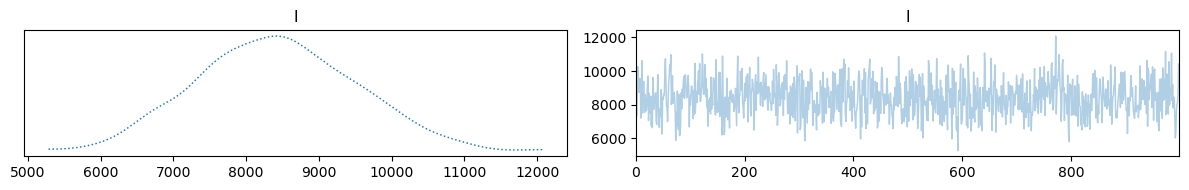

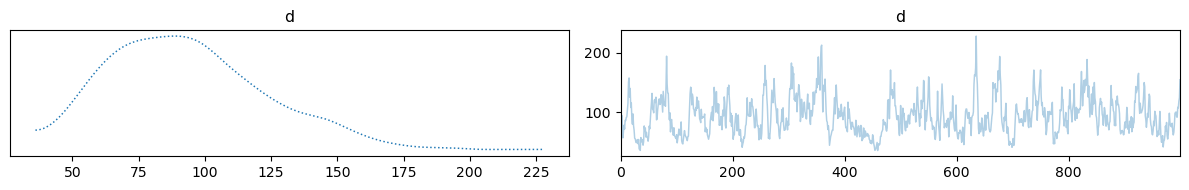

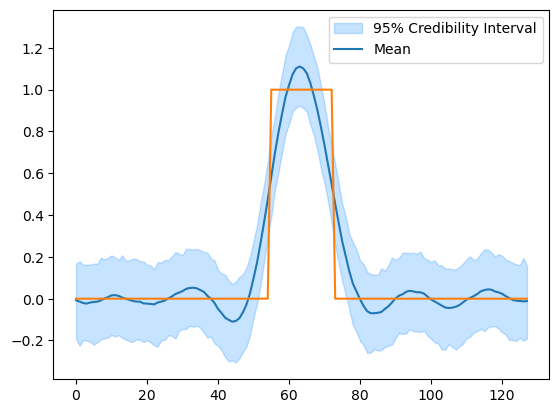

In [6]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = GMRF(np.zeros(n), prec = lambda d:d)
y = Gaussian(A@x, prec = lambda l:l)

joint = JointDistribution(d, l, x, y)
posterior = joint(y = y_data)

sampling_strategy = {
    'x': LinearRTO,
    'l': Conjugate,
    'd': GaussianGammaPair
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

In [7]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedGMRF(np.zeros(n), prec = lambda d:d, constraint="nonnegativity")
y = Gaussian(A@x, prec = lambda l:l)

joint = JointDistribution(d, l, x, y)
posterior = joint(y = y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': RegularizedGaussianGammaPair,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

ValueError: The likelihood needs to be RegularizedGaussian or RegularizedGMRF, but is <class 'cuqi.distribution._gaussian.Gaussian'>

Warmup 200 / 200
Sample 1000 / 1000


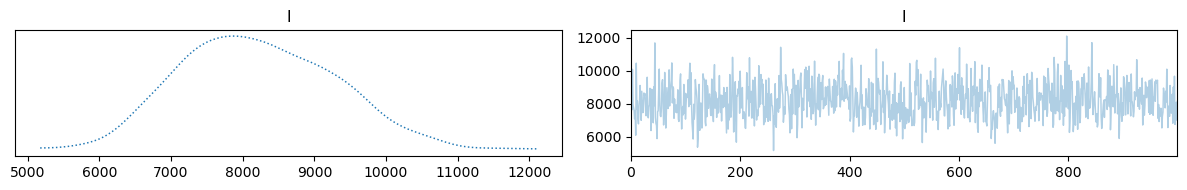

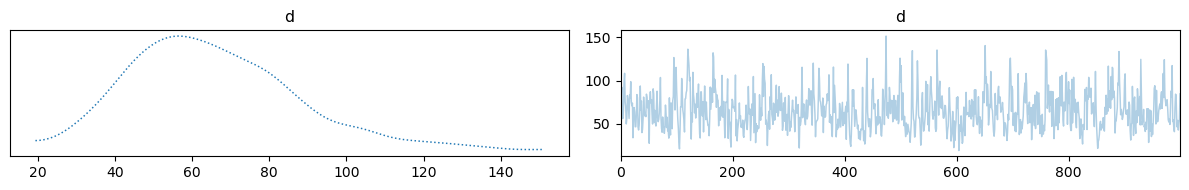

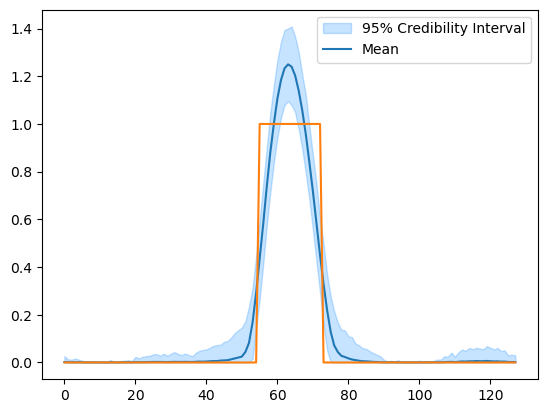

In [8]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedGMRF(np.zeros(n), prec = lambda d:d, constraint="nonnegativity")
y = Gaussian(A@x, prec = lambda l:l)

joint = JointDistribution(d, l, x, y)
posterior = joint(y = y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': GaussianGammaPair,
    'd': RegularizedGaussianGammaPair
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)